```
Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```



# Pathdreamer Example Colab

[Paper](https://arxiv.org/abs/2105.08756) | [Video](https://www.youtube.com/watch?v=StklIENGqs0)

This Colab demonstrates how to load and use a pretrained Pathdreamer model. This is part of the code for the paper "Pathdreamer: A World Model for Indoor Navigation" (ICCV 2021). The full codebase is found at https://github.com/google-research/pathdreamer/.

It is recommended that you run this Colab with a GPU runtime.

# Download code, model weights, and install dependencies

In [ ]:
%%shell
echo Installing code from GitHub...
apt install subversion
svn export --force https://github.com/google-research/pathdreamer/trunk pathdreamer

echo
echo Installing required dependencies.
pip install -r pathdreamer/requirements_colab.txt

echo
echo Fetching trained model weights...
mkdir data
rm -f data/ckpt.tar
rm -rf data/ckpt/
wget https://storage.googleapis.com/gresearch/pathdreamer/ckpt.tar -P data/
echo Extracting model weights...
tar -xf data/ckpt.tar --directory data/
echo Done.

## Imports and utils

In [ ]:
import tensorflow as tf
import math
import collections
import numpy as np
import json
import os
import io
import gzip
import base64
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

from pathdreamer.models import pathdreamer_models
from pathdreamer.models import pathdreamer_config
from pathdreamer.utils import utils
from pathdreamer import constants

devices = tf.config.experimental.list_logical_devices(device_type="GPU")
print([d.name for d in devices])
strategy = tf.distribute.MirroredStrategy(devices)

['/device:GPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
def show_animation(all_video_frames, main_titles=None, axis_titles=None, apply_cmap=False, figsize_scale=3, fps=10):
  images = []
  titles = []
  main_title = None
  legends = []
  max_frames = max([len(x) for x in all_video_frames])
  num_videos = len(all_video_frames)
  fig, ax = plt.subplots(1, num_videos, figsize=(figsize_scale * num_videos, figsize_scale))
  for i in range(num_videos):
    if num_videos == 1:
      axis = ax
    else:
      axis = ax[i]
    if num_videos != 1:
      axis = ax[i]
    curr_frame = all_video_frames[i][0]
    if apply_cmap:
      images.append(axis.imshow(cmap[curr_frame]))
    else:
      images.append(axis.imshow(curr_frame))
    if apply_cmap:
      legend_labels = np.unique(curr_frame)
      patches = [mpatches.Patch(color=cmap[x] / 255, label=x) for x in legend_labels if x != 0]
      legends.append(axis.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.))
    if axis_titles is not None:
      titles.append(axis.text(curr_frame.shape[1] // 2, 0, axis_titles[i][0],
                              horizontalalignment='center', verticalalignment='bottom'))
  if main_titles is not None:
    main_title = plt.figtext(0.5, 0.77, main_titles[0], fontdict={'size': 12}, ha='center', va='center')
  plt.tight_layout()
  plt.close()

  # function to update figure
  def updatefig(j):
      # set the data in the axesimage object
      for i in range(num_videos):
        frame_idx = min(j, len(all_video_frames[i])-1)
        if apply_cmap:
          images[i].set_array(cmap[all_video_frames[i][frame_idx]])
        else:
          images[i].set_array(all_video_frames[i][frame_idx])
        if axis_titles is not None:
          titles[i].set_text(axis_titles[i][j])
        if main_title is not None:
          main_title.set_text(main_titles[j])
      # return the artists set
      return images
  # kick off the animation
  ani = animation.FuncAnimation(fig, updatefig, frames=range(max_frames), 
                                interval=1000/fps, blit=True)
  rc('animation', html='jshtml')
  return ani

## Data

In [ ]:
cmap = utils.create_label_colormap()
image_height = 512
num_context = 1  # How many frames to provide to Pathdreamer as context.

Load an example panorama from [Matterport3D](https://niessner.github.io/Matterport/). This data is released by Matterport under the [Matterport3D Terms of Use](http://kaldir.vc.in.tum.de/matterport/MP_TOS.pdf).

In [ ]:
%%bash
wget https://storage.googleapis.com/gresearch/pathdreamer/example_pano.tar -P data/
tar -xf data/example_pano.tar --directory data/

In [ ]:
# Load an example pano.
base_dir = 'data/example_pano/'
with tf.io.gfile.GFile(os.path.join(base_dir, 'rgb.jpeg'), 'rb') as f:
  input_rgb_frames = tf.image.decode_jpeg(f.read())
  input_rgb_frames = tf.image.resize(input_rgb_frames, (image_height, image_height * 2), method='bilinear')
  input_rgb_frames = tf.cast(input_rgb_frames, tf.uint8)
with tf.io.gfile.GFile(os.path.join(base_dir, 'seg.png'), 'rb') as f:
  input_seg_frames = tf.image.decode_png(f.read())
  input_seg_frames = tf.image.resize(input_seg_frames, (image_height, image_height * 2), method='nearest')
  # Convert to index map of labels.
  input_seg_frames = utils.cmap_to_label(input_seg_frames, cmap)
  input_seg_frames = tf.cast(input_seg_frames, tf.int32)
with tf.io.gfile.GFile(os.path.join(base_dir, 'depth.png'), 'rb') as f:
  input_depth_frames = tf.image.decode_png(f.read())
  input_depth_frames = tf.image.resize(input_depth_frames, (image_height, image_height * 2), method='nearest')
  input_depth_frames = tf.cast(tf.clip_by_value(input_depth_frames / 255, 0, 1), tf.float32)

# Format example into (batch_size, height, width, channels) format.
input_rgb_frames = input_rgb_frames[None, ...]   # (1, 512, 1024, 3)
input_seg_frames = input_seg_frames[None, ..., None]   # (1, 512, 1024, 1)
input_depth_frames = input_depth_frames[None, ..., 0]   # (1, 512, 1024)

## Set up navigation trajectory

Set up a positions (xyz) tensor to indicate where to move to. z is up and y points towards the center of the equirectangular image.

In [ ]:
positions = tf.constant(
    [[[-4.35156, -1.06265,  1.50841],
    [-3.02035, -0.99548,  1.51129],
    [-1.43824, -1.19414,  1.51526]]], tf.float32)  # (1, 3, 3)

## Model

In [ ]:
config = pathdreamer_config.get_config()
config.ckpt_path = 'data/ckpt/structure_gen_ckpt'
config.spade_ckpt_path = 'data/ckpt/image_gen_ckpt'
stoch_model = pathdreamer_models.PathdreamerModel(config)

Restored from data/ckpt/structure_gen_ckpt
Restored SPADE from data/ckpt/image_gen_ckpt


# Image Generation

Pathdreamer can be used to synthesize image sequences in a navigation trajectory.

In [ ]:
num_frames = positions.shape[1]

# Reset and add initial observation as a context frame.
stoch_model.reset_memory()
stoch_model.add_to_memory(input_rgb_frames, input_seg_frames, input_depth_frames, positions[:, 0, :])

# Run inference for all positions.
predicted_data = collections.defaultdict(list)
total_dist = 0
for frame_idx in tqdm(range(0, num_frames), position=0):
  start_pos = positions[:, max(frame_idx-1, 0), :]
  end_pos = positions[:, frame_idx, :]
  dist = tf.norm(end_pos - start_pos)

  # Only add predicted points after the first step to memory.
  # The first step is trivially inferred from groundtruth information.
  add_to_mem = (frame_idx > 0)
  outputs = stoch_model(end_pos, add_preds_to_memory=add_to_mem, sample_noise=False)
  total_dist += dist
  predicted_data['distance'].append(total_dist.numpy())
  predicted_data['proj_rgb'].append(outputs.proj_rgb.numpy())
  predicted_data['proj'].append(outputs.proj_semantic.numpy())
  predicted_data['proj_depth'].append(outputs.proj_depth.numpy())
  predicted_data['rgb'].append(outputs.pred_rgb.numpy())
  predicted_data['seg'].append(outputs.pred_semantic.numpy())
  predicted_data['depth'].append(outputs.pred_depth.numpy())
  predicted_data['pos'].append(end_pos.numpy())

  0%|          | 0/3 [00:00<?, ?it/s]

Display results as a figure. The red line indicates the direction that the agent will move to next.

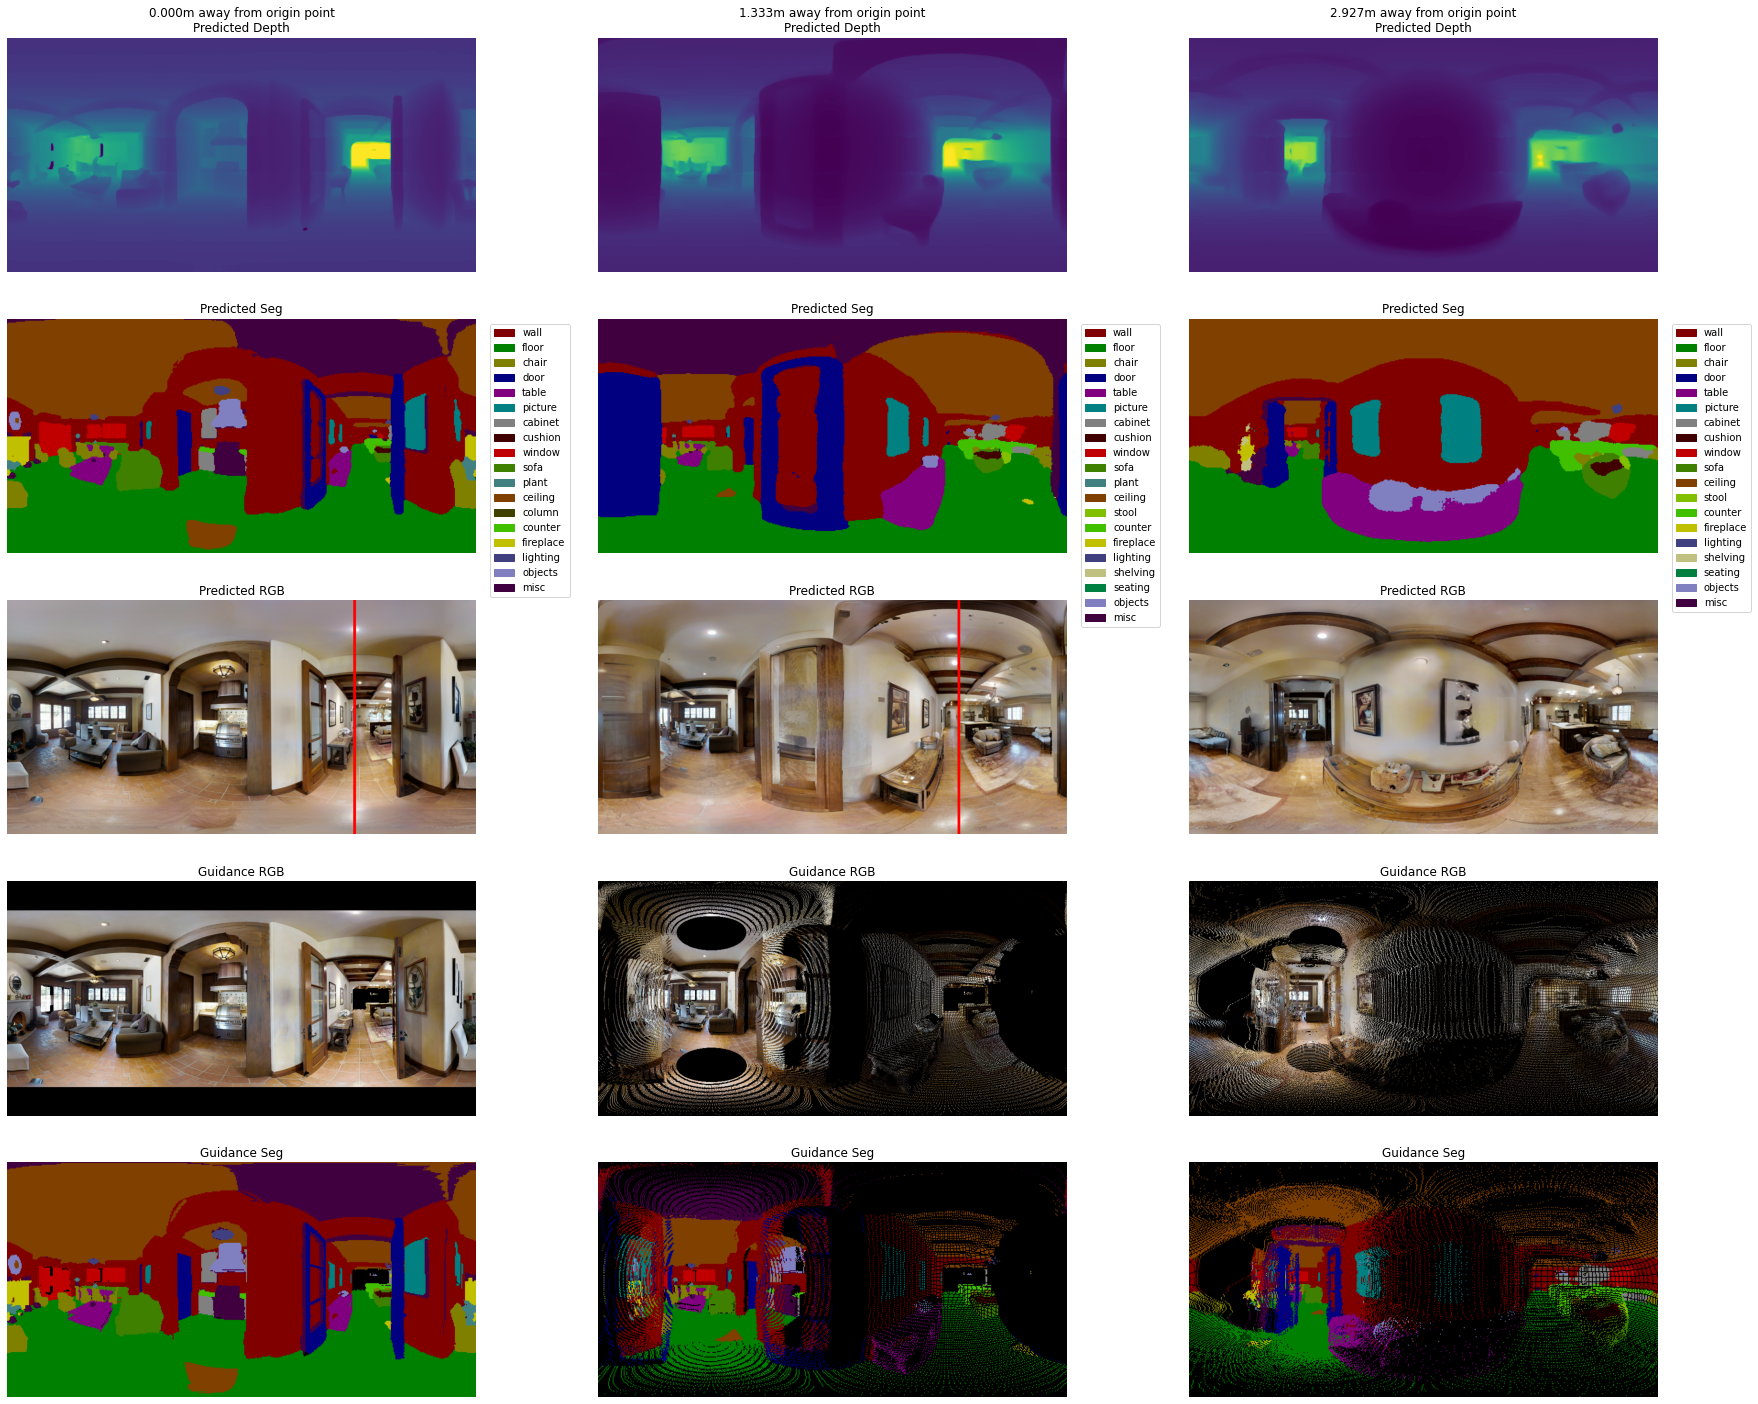

In [ ]:
def mark_heading_on_img(img, heading):
  width = img.shape[1]
  # Map to [0, 2pi] domain.
  heading = heading + (2 * math.pi) * tf.cast(heading <= 0, tf.float32) % (2 * math.pi)
  if heading < 0:
    heading += 2 * math.pi
  heading_deg = heading / (2 * math.pi) * 360
  heading_proportion = heading / (2 * math.pi)
  img[:, int(heading_proportion * width)-3:int(heading_proportion * width)+3, :] = [255, 0, 0]
  return img

size_scale = 5
num_display_items = 5
path_len = len(predicted_data['rgb'])
fig, ax = plt.subplots(
    num_display_items,
    path_len,
    figsize=(2 * size_scale * path_len, num_display_items * size_scale))

for i in range(path_len):
  pred_depth = predicted_data['depth'][i][0, ...]
  pred_rgb = predicted_data['rgb'][i][0, ...]
  proj_rgb = predicted_data['proj_rgb'][i][0, ...]
  proj_seg = cmap[predicted_data['proj'][i][0, ...]]
  seg = predicted_data['seg'][i][0, ...]
  pred_seg = cmap[seg]

  if i < path_len - 1:
    c1 = predicted_data['pos'][i][0, ...]
    c2 = predicted_data['pos'][i+1][0, ...]
    heading = tf.math.atan2(c1[0]-c2[0], c1[1]-c2[1])
    mark_heading_on_img(pred_rgb, heading)

  _ = ax[0, i].imshow(pred_depth)
  _ = ax[1, i].imshow(pred_seg)
  legend_labels = np.unique(seg)
  patches = []
  for x in legend_labels:
    if x != 0 and x in constants.MP3D_ID2CLASS:
      legend_patch = mpatches.Patch(
          color=cmap[x] / 255, label=constants.MP3D_ID2CLASS[x])
      patches.append(legend_patch)

  ax[0, i].set_title(f'{predicted_data["distance"][i]:.3f}m away from origin point\nPredicted Depth')
  ax[1, i].set_title('Predicted Seg')
  ax[1, i].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2)
  _ = ax[2, i].imshow(pred_rgb)
  ax[2, i].set_title('Predicted RGB')
  _ = ax[3, i].imshow(proj_rgb)
  ax[3, i].set_title('Guidance RGB')
  _ = ax[4, i].imshow(proj_seg)
  ax[4, i].set_title('Guidance Seg')
  for j in range(num_display_items):
    ax[j, i].axis('off')
plt.show()

## Continuous Video Generation

In addition to image generation, Pathdreamer can also be used for generating continuous video sequences ([video example](https://www.youtube.com/watch?v=StklIENGqs0)).

This can be done by interpolating between coordinates.

In [ ]:
# Distance between frames in metres. Predictions are sampled every distance_per_frame meters.
distance_per_frame = 0.1
update_every_dist = int(0.1 / distance_per_frame)  # Add points every x iteration.
num_frames = positions.shape[1]

# Reset and add initial observation as a context frame.
stoch_model.reset_memory()
stoch_model.add_to_memory(input_rgb_frames, input_seg_frames, input_depth_frames, positions[:, 0, :])

# Run inference.
predicted_data = collections.defaultdict(list)
total_dist = 0
for frame_idx in tqdm(range(1, num_frames), position=0):
  start_pos = positions[:, frame_idx-1, :]
  end_pos = positions[:, frame_idx, :]
  dist = tf.norm(end_pos - start_pos)
  num_sub_frames = int(dist / distance_per_frame)
  position_interpolations = np.linspace(start_pos, end_pos, num_sub_frames, endpoint=False)
  position_interpolations = np.transpose(position_interpolations, (1, 0, 2))  # (N, num_sub_frames, 3)
  for i in range(num_sub_frames):
    outputs = stoch_model(position_interpolations[:, i, :],
                          add_preds_to_memory=(i == 0),
                          sample_noise=False)
    total_dist += dist / num_sub_frames
    predicted_data['distance'].append(total_dist.numpy())
    predicted_data['proj_rgb'].append(outputs.proj_rgb.numpy())
    predicted_data['proj_seg'].append(outputs.proj_semantic.numpy())
    predicted_data['proj_depth'].append(outputs.proj_depth.numpy())
    predicted_data['pred_seg'].append(outputs.pred_semantic.numpy())
    predicted_data['pred_rgb'].append(outputs.pred_rgb.numpy())
    predicted_data['pred_depth'].append(outputs.pred_depth.numpy())

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Subtitles
distance_text = ['Groundtruth frame'] + [f'Distance traveled: {d:.2f}m' for d in predicted_data['distance']]

# RGB outputs
pathdreamer_rgb_frames = np.concatenate(
    [tf.cast(input_rgb_frames, tf.uint8)] + predicted_data['pred_rgb'],
    axis=0)
# Segmentation outputs
pathdreamer_seg_frames = np.concatenate(
    [tf.cast(input_seg_frames[..., 0], tf.int32)] + predicted_data['pred_seg'],
    axis=0)
pathdreamer_seg_frames = cmap[pathdreamer_seg_frames]
# Depth outputs
pathdreamer_depth_frames = np.concatenate(
    [tf.cast(input_depth_frames, tf.float32)] + predicted_data['pred_depth'],
    axis=0)

show_animation([pathdreamer_seg_frames, pathdreamer_rgb_frames], distance_text, figsize_scale=5)